100%|██████████| 21/21 [08:10<00:00, 23.34s/it]


Converged at iteration 152 with deviation 9.978097295970656e-05


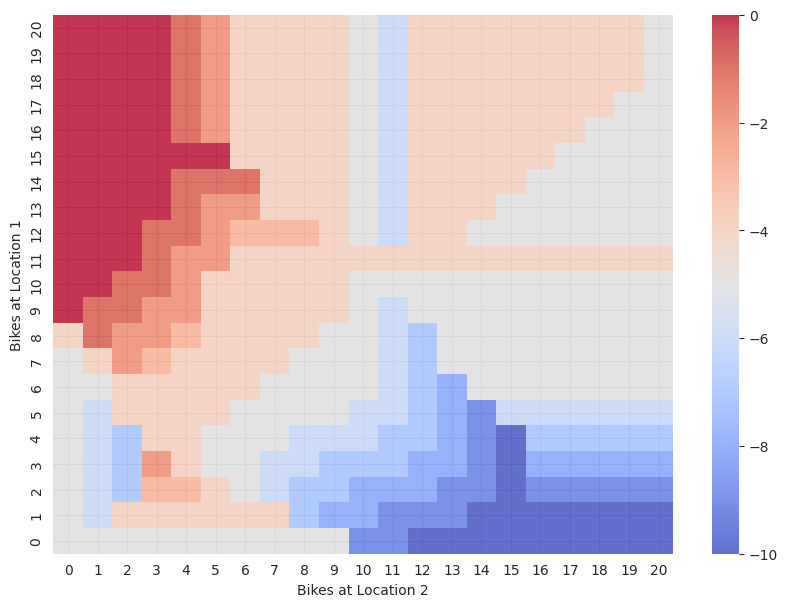

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm import tqdm

# Constants
max_bikes = 20
max_move = 5
gamma = 0.9
cost_per_move = 2
parking_cost = 4
num_actions = max_move * 2 + 1
price_per_bike = 10
penalty = 1000  # Penalty for invalid action

# Poisson parameters (average rental requests and returns)
lambdas = np.array([3, 4])  # Rental requests (Location 1, Location 2)
etas = np.array([3, 2])  # Bike returns (Location 1, Location 2)

# Employee bike shuttle assumption: 1 free move from Location 1 to Location 2
shuttle_cost = 0  # Employee-shuttled bike move cost

# State and action space dimensions
states = (max_bikes + 1) ** 2
actions = np.arange(-max_move, max_move + 1)  # Possible actions (move bikes between locations)

# Reward function
def reward_function(s1, s2, action):
    """Compute the reward for a given state (s1, s2) and action."""
    # Check for valid actions
    if action > s1 or action < -s2:
        return -penalty  # Invalid action: trying to move more bikes than available

    # Calculate bikes after action is performed
    s1_new = max(0, min(s1 - action, max_bikes))
    s2_new = max(0, min(s2 + action, max_bikes))

    # Revenue from rented bikes at each location (Poisson distribution)
    revenue1 = price_per_bike * sum(x * poisson.pmf(x, lambdas[0]) for x in range(1, s1_new + 1))
    revenue2 = price_per_bike * sum(x * poisson.pmf(x, lambdas[1]) for x in range(1, s2_new + 1))

    # Cost for moving bikes
    move_cost = shuttle_cost if action == 1 else abs(action) * cost_per_move

    # Parking cost if more than 10 bikes are at any location
    parking_cost1 = parking_cost if s1_new > 10 else 0
    parking_cost2 = parking_cost if s2_new > 10 else 0

    # Total reward
    total_reward = revenue1 + revenue2 - move_cost - parking_cost1 - parking_cost2
    return total_reward

# Transition probability function
def transition_prob(s1, s2, action):
    """Compute the transition probabilities for moving bikes between locations."""
    def prob_x(x, lambda_rate):
        """Probability of x bikes being rented out using Poisson distribution."""
        return poisson.pmf(x, lambda_rate)

    s1_new = max(0, min(s1 - action, max_bikes))
    s2_new = max(0, min(s2 + action, max_bikes))

    # Transition probabilities for each location
    P1 = np.zeros(max_bikes + 1)
    P2 = np.zeros(max_bikes + 1)

    for x1 in range(max_bikes + 1):
        for x2 in range(max_bikes + 1):
            P1[x1] = prob_x(x1, lambdas[0])
            P2[x2] = prob_x(x2, lambdas[1])

    return np.outer(P1, P2)

# Precompute rewards and transition probabilities
ER = np.empty((max_bikes + 1, max_bikes + 1, num_actions))
P = np.empty((max_bikes + 1, max_bikes + 1, num_actions, max_bikes + 1, max_bikes + 1))

for s1 in tqdm(range(max_bikes + 1)):
    for s2 in range(max_bikes + 1):
        for action_idx in range(num_actions):
            action = actions[action_idx]
            # Store the reward for this state-action pair
            ER[s1, s2, action_idx] = reward_function(s1, s2, action)
            # Store transition probabilities for this state-action pair
            P[s1, s2, action_idx] = transition_prob(s1, s2, action)

# Reshape P to match the expected shape (states, actions, states')
P = P.reshape((states, num_actions, states))

# Value Iteration
def update_value_function(v, ER, P, gamma):
    # Iterate over all states and actions
    new_v = np.zeros_like(v)
    for s1 in range(max_bikes + 1):
        for s2 in range(max_bikes + 1):
            for action_idx in range(num_actions):
                action = actions[action_idx]
                # Calculate the expected value for this state-action pair
                transition_probabilities = P[s1 * (max_bikes + 1) + s2, action_idx]
                new_v[s1 * (max_bikes + 1) + s2] = np.max(ER[s1, s2, action_idx] + gamma * np.dot(transition_probabilities, v))
    return new_v

def value_iteration(ER, P, gamma, max_iter=1000, threshold=1e-4):
    v = np.zeros(states)  # Initialize value function
    for i in range(max_iter):
        v_new = update_value_function(v, ER, P, gamma)
        deviation = np.max(np.abs(v_new - v))
        v = v_new
        if deviation <= threshold:
            print(f"Converged at iteration {i + 1} with deviation {deviation}")
            break
    return v


# Perform value iteration
v = value_iteration(ER, P, gamma)

# Policy Extraction from Value Function
def extract_policy(v, ER, P, gamma):
    # Initialize an array to hold the best actions
    policy = np.zeros((max_bikes + 1, max_bikes + 1), dtype=int)

    for s1 in range(max_bikes + 1):
        for s2 in range(max_bikes + 1):
            # Get the expected future value for each action at this state
            expected_values = np.zeros(num_actions)

            for action_idx in range(num_actions):
                action = actions[action_idx]

                # Calculate the expected value for this state-action pair
                transition_probabilities = P[s1 * (max_bikes + 1) + s2, action_idx]  # Transition probabilities for this action
                expected_values[action_idx] = ER[s1, s2, action_idx] + gamma * np.dot(transition_probabilities, v)

            # Select the action that maximizes the expected value
            policy[s1, s2] = actions[np.argmax(expected_values)]  # Best action for this state

    return policy

policy = extract_policy(v, ER, P, gamma)

# Visualize the Results
policy_matrix = (policy - max_move).reshape((max_bikes + 1, max_bikes + 1))
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(policy_matrix, ax=ax, cmap="coolwarm", alpha=0.8)
ax.set_xlabel("Bikes at Location 2")
ax.set_ylabel("Bikes at Location 1")
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
